# Stat222 HW2

Seokjun Choi

*All code blocks are Python scripts.*

## Question 2

*Python script:*
- Q2: https://github.com/letsjdosth/bnp/blob/main/hw2_q2.py
- and it depends on hw1's script: https://github.com/letsjdosth/bnp/blob/main/dp_generator.py

Let me generate two sets of simulated data with size 300 for each, following
- pois(5)
- 0.7pois(3) + 0.3pois(11)

I will provide the realization's histograms below.

In [1]:
from math import inf, log
from random import seed, uniform, betavariate, randint

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pyBayes.MCMC_Core import MCMC_MH, MCMC_Diag, MCMC_base
from pyBayes.util_MCMC_proposal import unif_proposal_log_pdf, unif_proposal_sampler
from dp_generator import DirichletProcessGenerator_StickBreaking

seed(20230503+7)
np.random.seed(20230513+7)

#generate data
pois5_300 = sp.stats.poisson.rvs(5,size=300)

pois_mixture_300 = []
for i in range(300):
    u = uniform(0, 1)
    if u<0.7:
        pois_mixture_300.append(sp.stats.poisson.rvs(3))
    else:
        pois_mixture_300.append(sp.stats.poisson.rvs(11))

Using the marginalized likelihood, I will generate $\alpha$ and $\lambda$ via MCMC.
Please see the attached note for the detailed expression.

We do not have prior information.
For the prior's parameters of $a_\alpha, b_\alpha$ and $a_\lambda, b_\lambda$, I just set $1$ for all. (For these notations, please see the note again.)
It is tricky whether a pair of smaller values $a_\alpha, b_\alpha$ yields less powerful prior or not for $\alpha$.
However, generally, setting $\alpha=1$ for DP prior seems a convention(?) for a weak DP prior, so I put $a_\alpha=b_\alpha=1$ to make its mean 1.
Perhaps $a_\alpha=b_\alpha=0.01$ may be better, but $1,1$ can be also considered as one of the natural ways.

For $\lambda$, which indicates $G_0$'s mean, a better choice would have been a pair yielding a gamma density having more variance with a heavier tail.
But, again, $1,1$ can be considered as one of the natural ways in this case, too.

For proposal distribution inside the MCMC, I will use a continuous uniform distribution with window size $w$, $unif(max(0,x-0.5w), x+0.5w)$, when $x$ is the last sample. 
For $\alpha$, $w=3$ is chosen, and for $\lambda$, $w=1$ is selected based on some traceplot diagnosis.
Note that it is not symmetric at the neighborhood of zero, but we can adjust it when we calculate the acceptance-rejection ratio.

In [2]:
class HW2_Q2_alpha_lambda_sampler(MCMC_base):
    def __init__(self, data: list, initial, hyper=None):
        #G~DP(alpha, G0=Pois(lambda))
        self.y_list = data
        self.n = len(data)
        self.y_dict = {}
        for y in self.y_list:
            try:
                self.y_dict[y] += 1
            except KeyError:
                self.y_dict[y] = 1
        self.n_star = len(self.y_dict.keys())

        self.MC_sample = [initial]
        
        if hyper==None:
            self.hyper_a_alpha = 1
            self.hyper_b_alpha = 1
            self.hyper_a_lambda = 1
            self.hyper_b_lambda = 1
        else:
            self.hyper_a_alpha = hyper["a_alpha"]
            self.hyper_b_alpha = hyper["b_alpha"]
            self.hyper_a_lambda = hyper["a_lambda"]
            self.hyper_b_lambda = hyper["b_lambda"]

    def _calculate_marginal_log_likelihood(self, alpha, lamb):
        log_val = self.n_star * log(alpha) - sum([log(alpha+i) for i in range(0, self.n)])
        for y_star_j, n_j in self.y_dict.items():
            pois_pmf_val = sp.stats.poisson.pmf(y_star_j, lamb)
            log_val += log(pois_pmf_val)
            for i in range(1, n_j):
                log_val += log(alpha*pois_pmf_val + i)
        return log_val

    def sampler(self, **kwargs):
        # alpha, lambda
        
        def _log_target(sample):
            alpha = sample[0]
            lamb = sample[1]
            log_val = self._calculate_marginal_log_likelihood(alpha, lamb)
            log_val += sp.stats.gamma.logpdf(alpha, self.hyper_a_alpha, 1/self.hyper_b_alpha)
            log_val += sp.stats.gamma.logpdf(lamb, self.hyper_a_lambda, 1/self.hyper_b_lambda)
            return log_val

        def _proposal_sampler(last):
            # alpha, lambda
            new_alpha = unif_proposal_sampler([last[0]], 0, inf, 3)
            new_lambda = unif_proposal_sampler([last[1]], 0, inf, 1)
            return [new_alpha[0], new_lambda[0]]

        def _proposal_log_density(from_smpl, to_smpl):
            # alpha, lambda
            log_val = unif_proposal_log_pdf([from_smpl[0]], [to_smpl[0]], 0, inf, 3)
            log_val += unif_proposal_log_pdf([from_smpl[1]], [to_smpl[1]], 0, inf, 1)
            return log_val
        
        initial = self.MC_sample[-1]
        MCMC_inst = MCMC_MH(_log_target, _proposal_log_density, _proposal_sampler, initial)
        MCMC_inst.generate_samples(3, verbose=False)
        new_a_lambda_sample = MCMC_inst.MC_sample[-1]
        self.MC_sample.append(new_a_lambda_sample)

class Post_DP_Q2(DirichletProcessGenerator_StickBreaking):
    def __init__(self, data, set_seed) -> None:
        self.y = data
        self.n = len(data)
        seed(set_seed)
        self.atom_loc = None
        self.atom_weight = None

    def atom_sampler(self, a_lamb_sample, num_atom: int):
        precision = a_lamb_sample[0]
        lamb = a_lamb_sample[1]

        atom_loc = []
        for _ in range(num_atom):
            unif_sample = uniform(0,1)
            if unif_sample < precision/(precision+len(self.y)):
                loc = sp.stats.poisson.rvs(lamb)
            else:
                loc = self.y[randint(0, len(self.y)-1)]
            atom_loc.append(loc)
            
        left_stick_length = 1.0
        atom_weight = []
        for _ in range(num_atom-1):
            portion = betavariate(1, precision+len(self.y))
            weight = portion * left_stick_length
            atom_weight.append(weight)
            left_stick_length = left_stick_length * (1 - portion)
        atom_weight.append(left_stick_length)
        return atom_loc, atom_weight

### poisson(5) case

I plot a histogram of realization of 300 samples.

Then, I run 4,000 iterations of MCMC and cut 2,000 at the head.


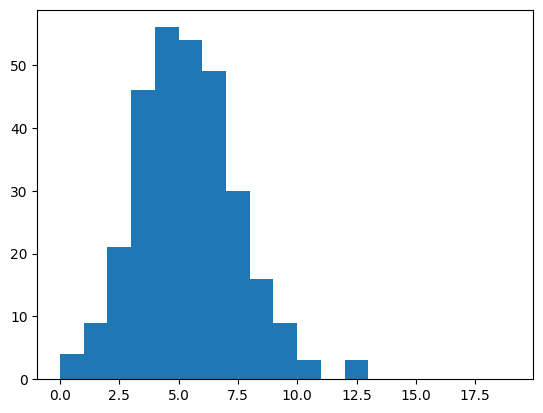

estimated running time:  0.0 min  28.09722900390625 sec
iteration 500 / 4000
iteration 1000 / 4000
iteration 1500 / 4000
iteration 2000 / 4000
iteration 2500 / 4000
iteration 3000 / 4000
iteration 3500 / 4000
iteration 4000 / 4000  done! (elapsed time for execution:  0.0 min  25.405282735824585 sec)


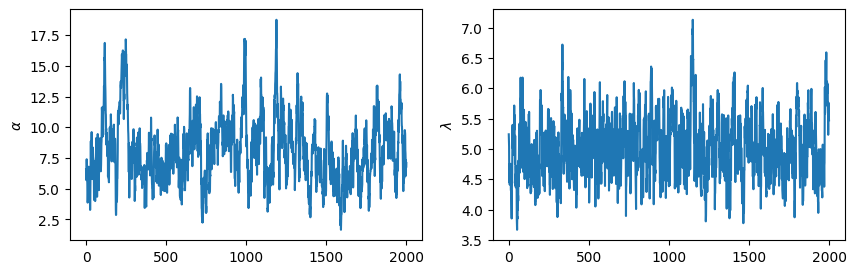

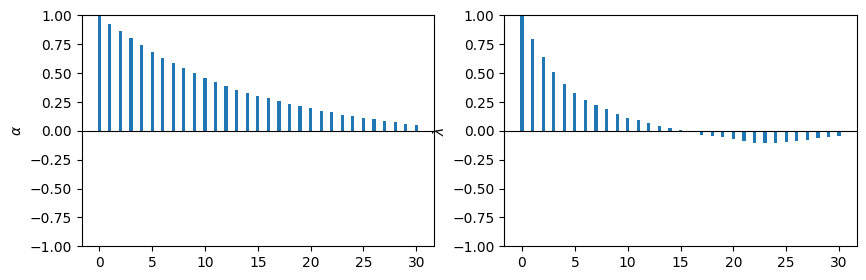

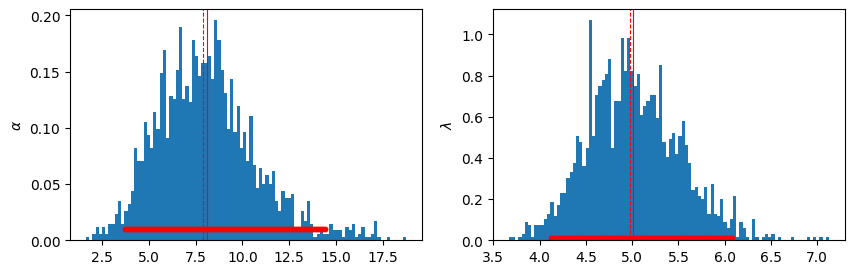

param 		 mean 	 var 	 95%CI
$\alpha$ 		 8.086 	 6.978 	 [3.71, 14.408]
$\lambda$ 		 5.015 	 0.245 	 [4.127, 6.08]


In [3]:

plt.hist(pois5_300, bins=[i for i in range(20)])
plt.show()
fit_inst = HW2_Q2_alpha_lambda_sampler(pois5_300, [10, 10], None)
fit_inst.generate_samples(4000)
diag_inst = MCMC_Diag()
diag_inst.set_mc_samples_from_list(fit_inst.MC_sample)
diag_inst.set_variable_names([r"$\alpha$",r"$\lambda$"])
diag_inst.burnin(2000)

diag_inst.show_traceplot((1,2))
diag_inst.show_acf(30, (1,2))
diag_inst.show_hist((1,2))
diag_inst.print_summaries(3)

Based on traceplots and acf plots, convergence seems good.
On the histograms, the red horizontal line indicates the mean, the red dotted line is the median, and the red horizontal line means the 95% credible interval.
Please be careful when seeing the summary table. The colume labels do not match well. (sorry, it is my bad.)

Based on generated samples, let me construct the realization of G's posterior using a stick-breaking process.
A detailed algorithm is described in the attached note, as well.

I will show three plots,
- realized distribution function(cdf) based on the posterior of $G$ (blue) and true DGP's cdf (red)
- pointwise boxplots based on realized atoms from stick-breaking to see the mass function and true mass function(red)
- 95% credible interval and median based on atoms, true mass function(red), and realized data (light-blue histogram)

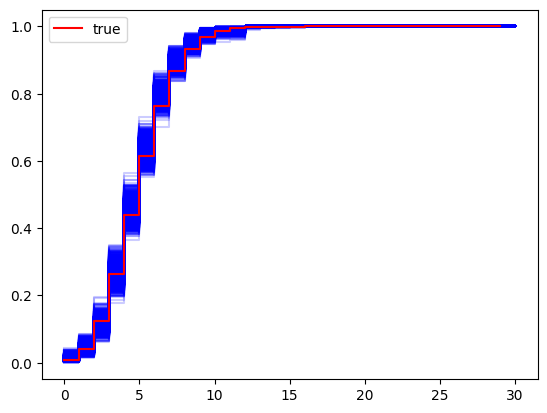

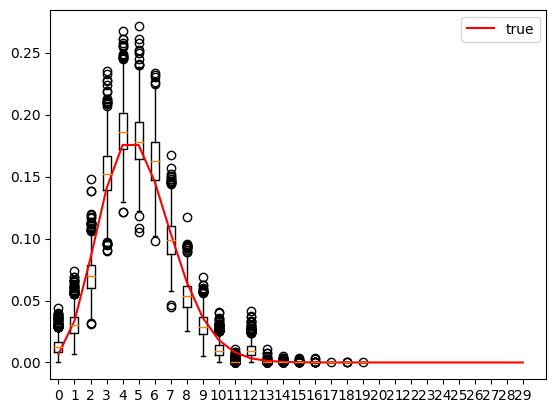

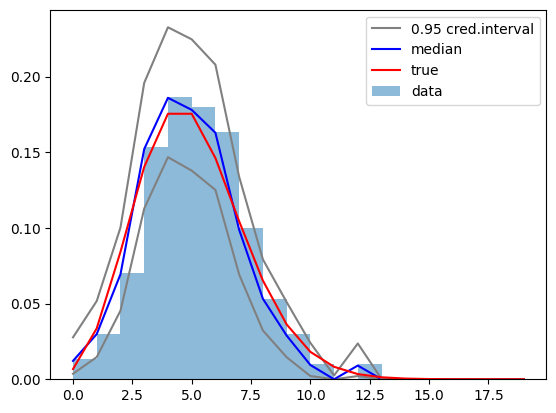

In [4]:
cdf_inst = Post_DP_Q2(pois5_300, 20230504)
density_boxplot_mat = []
for mc_sample in diag_inst.MC_sample:
    atom_loc, atom_weight = cdf_inst.atom_sampler(mc_sample, 3000)
    unified_grid = [i for i in range(0, 20)]
    unified_weight = cdf_inst.atom_loc_unifier_by_expansion(unified_grid, atom_loc, atom_weight)
    density_boxplot_mat.append(unified_weight)

    grid, increments, sample_path = cdf_inst.cumulatative_dist_func(atom_loc, atom_weight, 0, 30)

    plt.step(grid, sample_path, where='post', alpha=0.2, c='blue')
plt.step(np.arange(0,30),sp.stats.poisson.cdf(np.arange(0,30), mu=5), where='post', c='red', label='true')
plt.legend()
plt.show()

plt.boxplot(np.array(density_boxplot_mat))
plt.xticks(np.arange(1,31), np.arange(0,30))
plt.plot(np.arange(1,31), sp.stats.poisson.pmf(np.arange(0,30), mu=5), c='red', label='true')
plt.legend()
plt.show()

quant = np.quantile(density_boxplot_mat, q=[0.025, 0.5, 0.975], axis=0)
plt.plot(np.arange(0,20), quant[0,:], c='gray', label='0.95 cred.interval')
plt.plot(np.arange(0,20), quant[1,:], c='blue', label='median')
plt.plot(np.arange(0,20), quant[2,:], c='gray')
plt.plot(np.arange(0,20), sp.stats.poisson.pmf(np.arange(0,20), mu=5), c='red', label='true')
plt.hist(pois5_300, bins=[i for i in range(20)], density=True, alpha=0.5, label='data')
plt.legend()
plt.show()

**Caution:**
- *All values are on each integer value, 0, 1, 2, ...*
- *Histogram's every bin indicates $[x,x+1)$, for an integer $x$ (it would be better if I can move the bar by 0.5 left)
- *and true cdf and realized median/quantiles are only at 0, 1, 2,...*

*(It is my bad to fail adjusting the x-axis's ticks.)*

*note: I failed to delete the points outside the boxplot's whiskers. Hmm... I will try to fix them later.*

Everything seems good. 
The dark-blue area, which indicates dense realizations, covers the true cdf(red) in the first plot.
Each box can catch the true value(red curve) quite well in the boxplot.
In the last plot, except for at 11, the 95% credible interval reasonably covers(grey) the true mass function(red), and the median(blue) is close to the true as well.

One realization at 12 makes a small peak at the right tail, but I do not want to say it is bad.
It would be fairer to say that our model faithfully represents the data.

### Mixture case

I repeat the same procedure with the other simulated dataset of $0.7pois(3) + 0.3pois(11)$.

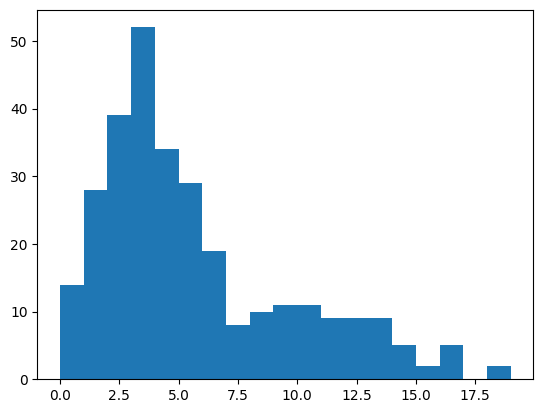

In [5]:
plt.hist(pois_mixture_300, bins=[i for i in range(20)])
plt.show()

From the histogram of realized observations, we can see two peaks, even if the second peak is small.
At 16, samples were realized quite a lot compared to the true mass.

estimated running time:  0.0 min  41.65876388549805 sec
iteration 500 / 4000
iteration 1000 / 4000
iteration 1500 / 4000
iteration 2000 / 4000
iteration 2500 / 4000
iteration 3000 / 4000
iteration 3500 / 4000
iteration 4000 / 4000  done! (elapsed time for execution:  0.0 min  40.04802179336548 sec)


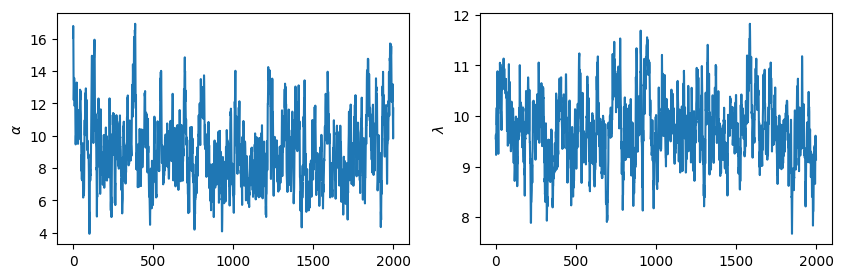

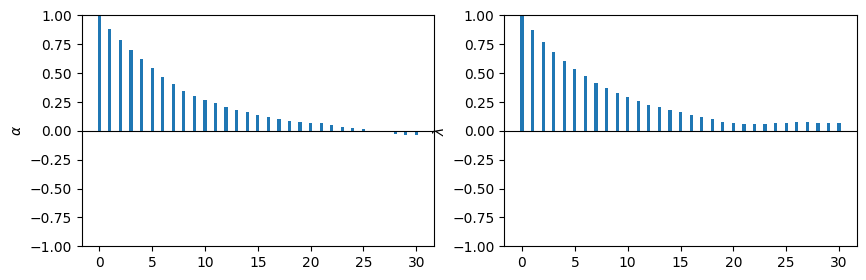

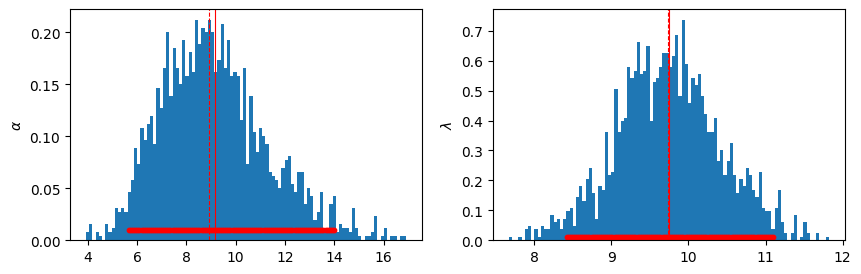

param 		 mean 	 var 	 95%CI
$\alpha$ 		 9.145 	 4.669 	 [5.682, 13.983]
$\lambda$ 		 9.745 	 0.447 	 [8.422, 11.101]


In [6]:
fit_inst = HW2_Q2_alpha_lambda_sampler(pois_mixture_300, [10, 10], None)
fit_inst.generate_samples(4000)
diag_inst = MCMC_Diag()
diag_inst.set_mc_samples_from_list(fit_inst.MC_sample)
diag_inst.set_variable_names([r"$\alpha$",r"$\lambda$"])
diag_inst.burnin(2000)

diag_inst.show_traceplot((1,2))
diag_inst.show_acf(30, (1,2))
diag_inst.show_hist((1,2))
diag_inst.print_summaries(3)

For $\alpha$ and $\lambda$, I run 4,000 iterations of MCMC and cut the first 2,000 as a burn-in period.
If we focus on traceplots and acf plots, convergence seems good.
Again, on the histograms, the red horizontal line indicates the mean, the red dotted line is the median, and the red horizontal line means the 95% credible interval.

Next, I present three figures of the same configuration as above.

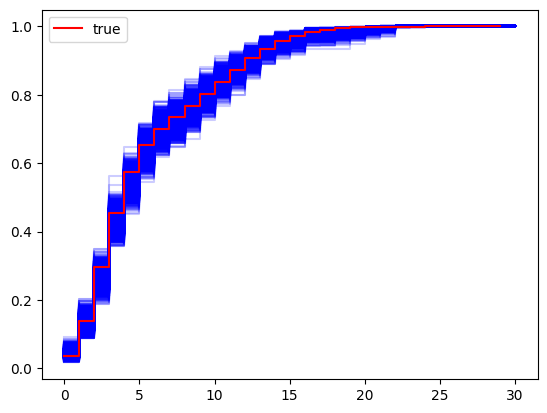

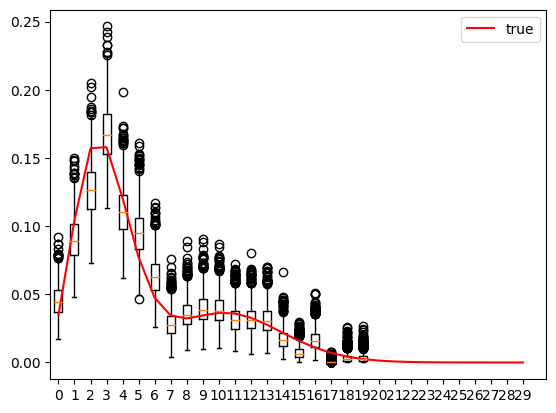

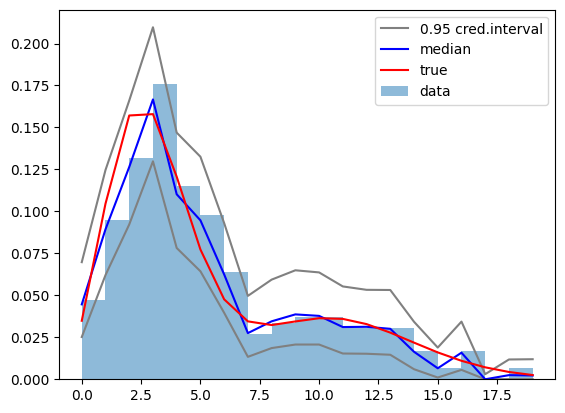

In [7]:
cdf_inst = Post_DP_Q2(pois_mixture_300, 20230504)
density_boxplot_mat = []
for mc_sample in diag_inst.MC_sample:
    atom_loc, atom_weight = cdf_inst.atom_sampler(mc_sample, 3000)
    unified_grid = [i for i in range(0, 20)]
    unified_weight = cdf_inst.atom_loc_unifier_by_expansion(unified_grid, atom_loc, atom_weight)
    density_boxplot_mat.append(unified_weight)

    grid, increments, sample_path = cdf_inst.cumulatative_dist_func(atom_loc, atom_weight, 0, 30)

    plt.step(grid, sample_path, where='post', alpha=0.2, c='blue')
plt.step(np.arange(0,30), 0.7*sp.stats.poisson.cdf(np.arange(0,30), mu=3) + 0.3*sp.stats.poisson.cdf(np.arange(0,30), mu=11), where='post', c='red', label='true')
plt.legend()
plt.show()

plt.boxplot(np.array(density_boxplot_mat))
plt.xticks(np.arange(1,31), np.arange(0,30))
plt.plot(np.arange(1,31), 0.7*sp.stats.poisson.pmf(np.arange(0,30), mu=3) + 0.3*sp.stats.poisson.pmf(np.arange(0,30), mu=11), c='red', label='true')
plt.legend()
plt.show()

quant = np.quantile(density_boxplot_mat, q=[0.025, 0.5, 0.975], axis=0)
plt.plot(np.arange(0,20), quant[0,:], c='gray', label='0.95 cred.interval')
plt.plot(np.arange(0,20), quant[1,:], c='blue', label='median')
plt.plot(np.arange(0,20), quant[2,:], c='gray')
plt.plot(np.arange(0,20), 0.7*sp.stats.poisson.pmf(np.arange(0,20), mu=3) + 0.3*sp.stats.poisson.pmf(np.arange(0,20), mu=11), c='red', label='true')
plt.hist(pois_mixture_300, bins=[i for i in range(20)], density=True, alpha=0.5, label='data')
plt.legend()
plt.show()

I'm sorry for the status of the bad x-axis. But let me repeat the caution again.

**Caution:**
- *All values are on each integer value, 0, 1, 2, ...*
- *Histogram's every bin indicates $[x,x+1)$, for an integer $x$ (it would be better if I can move the bar by 0.5 left)
- *and true cdf and realized median/quantiles are only at 0, 1, 2,...*

From the pointwise posterior median of G, we can see the model catches two peaks well. 
(Oh, actually, we can see the third peak around the 16 because of some sample's realization. But it is small enough.)

The dense area of realized distribution function paths covers the true cdf well in the first plot.
Boxplots and the 95% credible interval reasonably catch the true(red) mass function in the second and third plots.
The posterior median is close to the true mass function as well.

We have seen that a mixture of DP(MDP) is quite flexible.
I checked that its performance gets better if I use a larger dataset, like $n=1000$, even if I did not report it here.
According to my observation so far, compared to Bayesian parametric models, Bayesian nonparametric models tend to follow meticulously down to very minor details.
But at the same time, to get a reliable (less uncertain and closer to the true) result, nonparametric models may tend to require larger $n$ than parametric models.